# Visualize imp wts pattern across rounds

In [9]:
import pickle
exp_savefile = "exper25K_1per_aug_chunkfix"
imp_wts = pickle.load(open("Save/Imp_weights/imp_wts_idxs_" + exp_savefile + ".p", "rb"))
type(imp_wts[0])

list

In [9]:
import numpy as np
len(np.sum(imp_wts[1]))

7014

In [10]:
import torch
import resnet
import numpy as np

model = resnet.ResNet18()
filename = exp_savefile #"exper25K_1per_aug" #"exper25K_2per" #
rd = 7
model.load_state_dict(torch.load("./Save/Models/"+ exp_savefile +"/model_" +  str(rd) + ".pt",map_location=torch.device('cpu')))

# print(len(imp_wts[0][0])) # = number of imp wts in round 0 and layer 0

frac_imp = {l: [] for l in range(len(imp_wts[0]))}
for layer_num, param in enumerate(model.parameters()):
    frac_imp[layer_num] = [len(imp_wts[rd][layer_num]) / np.prod(param.shape) for rd in range(len(imp_wts))]


In [78]:
import random
mask_size = 7014
num_params = sum(p.numel() for p in model.parameters())
model_shape = []
for i in model.parameters():
    model_shape.append(list(i.size()))

flat_model_shape = []
for i in model.parameters():
    flat_model_shape.append(np.prod(list(i.size())))
cum_lengths = np.cumsum(flat_model_shape)

imp_wt_idxs = [[] for i in range(len(model_shape))]
for i in range(mask_size):
    rand_wt = random.randint(0,num_params)
    prev_length = 0
    for idx_layer_num, length in enumerate(cum_lengths):
        if rand_wt < length and length > prev_length: 
            try:
                distance_into_layer = rand_wt-prev_length
                layer_shape = model_shape[idx_layer_num] #[16,3,3,3]
                # layer_shape[0] = 1 #[1,3,3,3]
                # layer_shape = np.cumprod(layer_shape) #[1,3,9,27]
                # layer_shape = np.flip(layer_shape) #[27,9,3,1]
                # idx_tuple = []
                # for i in layer_shape:
                #     idx_tuple.append(int(distance_into_layer/i))
                #     distance_into_layer -= (idx_tuple[-1] * i)
                idx_tuple = np.unravel_index(distance_into_layer, layer_shape)
            except Exception:
                print("caught error: ", rand_wt, idx_layer_num, prev_length, length, imp_wt_idxs)
                raise
            imp_wt_idxs[idx_layer_num].append(idx_tuple)
            break
        prev_length = length

In [79]:
print(sum([len(p) for p in imp_wt_idxs]))

7014


In [77]:
print(imp_wt_idxs)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [(2, 3, 0, 0)], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [35]:
modelshape = []
for i in model.parameters():
    modelshape.append(np.prod(list(i.size())))

In [2]:
import numpy as np
x = [16, 3, 3, 3]
x[0] = 1

x = np.cumprod(x)
#x = np.flip(x)
print(x)

[ 1  3  9 27]


In [55]:
distance_into_layer = 13 #90
layer_shape = [3, 2, 4] #[16,3,3,3]
layer_shape[0] = 1 #[1,3,3,3]
layer_shape = np.cumprod(layer_shape) #[1,3,9,27]
layer_shape = np.flip(layer_shape)
idx_tuple = []
for i in layer_shape:
    quotient = distance_into_layer // i
    idx_tuple.append(min(quotient, i-1))
    distance_into_layer -= (idx_tuple[-1] * i)


print(idx_tuple, distance_into_layer)

[1, 1, 0] 3


In [56]:
np.unravel_index(13, [3, 2, 4])

(1, 1, 1)

In [57]:
a = rng.random([3, 2, 4])
a

array([[[0.75385509, 0.33195593, 0.33499526, 0.27256784],
        [0.47616853, 0.60096067, 0.82671665, 0.53005927]],

       [[0.78252334, 0.97152606, 0.32029759, 0.92098799],
        [0.36617022, 0.87312621, 0.00440348, 0.75833655]],

       [[0.66216667, 0.9086491 , 0.25535466, 0.7913724 ],
        [0.10748033, 0.06300311, 0.5662342 , 0.97893329]]])

In [59]:
print(a.flatten(), a.flatten()[13])

[0.75385509 0.33195593 0.33499526 0.27256784 0.47616853 0.60096067
 0.82671665 0.53005927 0.78252334 0.97152606 0.32029759 0.92098799
 0.36617022 0.87312621 0.00440348 0.75833655 0.66216667 0.9086491
 0.25535466 0.7913724  0.10748033 0.06300311 0.5662342  0.97893329] 0.8731262091838597


In [71]:
distance_into_layer = 90
layer_shape = [16,3,3,3]
# layer_shape[0] = 1 #[1, 2, 4]
layer_shape = np.flip(layer_shape)

layer_shape = np.cumprod(layer_shape) #[1,3,9,27]

layer_shape = np.hstack([1, layer_shape[:-1]])
print(layer_shape)
idx_tuple = []
for i in reversed(layer_shape):
    quotient = distance_into_layer // i
    idx_tuple.append(quotient)
    distance_into_layer -= (idx_tuple[-1] * i)

print(idx_tuple, distance_into_layer)

[ 1  3  9 27]
[3, 1, 0, 0] 0


In [72]:
np.unravel_index(90, [16, 3, 3, 3])

(3, 1, 0, 0)

In [38]:
print(len(modelshape))

61


In [17]:
for name, i in model.named_parameters():
    print(name, i.shape)

conv1.weight torch.Size([16, 3, 3, 3])
bn1.weight torch.Size([16])
bn1.bias torch.Size([16])
layer1.0.conv1.weight torch.Size([16, 16, 3, 3])
layer1.0.bn1.weight torch.Size([16])
layer1.0.bn1.bias torch.Size([16])
layer1.0.conv2.weight torch.Size([16, 16, 3, 3])
layer1.0.bn2.weight torch.Size([16])
layer1.0.bn2.bias torch.Size([16])
layer1.1.conv1.weight torch.Size([16, 16, 3, 3])
layer1.1.bn1.weight torch.Size([16])
layer1.1.bn1.bias torch.Size([16])
layer1.1.conv2.weight torch.Size([16, 16, 3, 3])
layer1.1.bn2.weight torch.Size([16])
layer1.1.bn2.bias torch.Size([16])
layer2.0.conv1.weight torch.Size([32, 16, 3, 3])
layer2.0.bn1.weight torch.Size([32])
layer2.0.bn1.bias torch.Size([32])
layer2.0.conv2.weight torch.Size([32, 32, 3, 3])
layer2.0.bn2.weight torch.Size([32])
layer2.0.bn2.bias torch.Size([32])
layer2.0.shortcut.0.weight torch.Size([32, 16, 1, 1])
layer2.0.shortcut.1.weight torch.Size([32])
layer2.0.shortcut.1.bias torch.Size([32])
layer2.1.conv1.weight torch.Size([32, 32,

In [14]:
sum(p.numel() for p in model.parameters())

701456

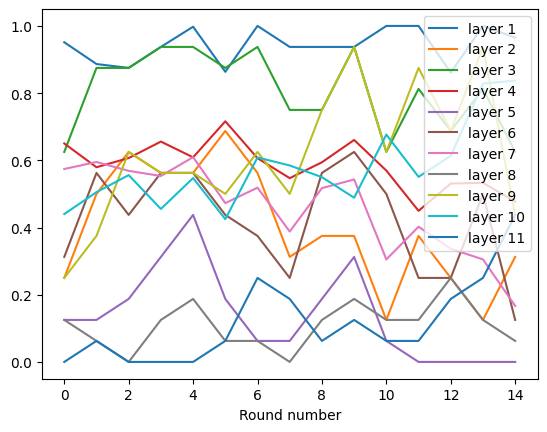

In [6]:
import matplotlib.pyplot as plt

i = 0
for frac in frac_imp.values():
    i += 1
    if i > 0:
        plt.plot(frac, label=F'layer {i}')
    else:
        continue
    if i > 10: 
        break

plt.legend()
plt.xlabel('Round number')
plt.show()

In [28]:
np.std(frac_imp[8])

0.16276687487187175

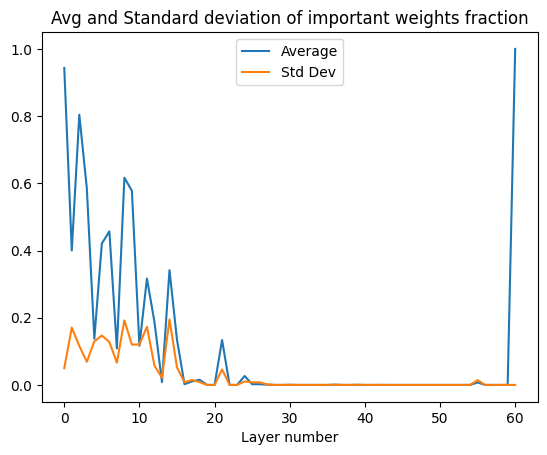

In [7]:
import matplotlib.pyplot as plt
plt.plot([np.average(frac_imp[l]) for l in range(61)], label='Average')
plt.plot([np.std(frac_imp[l]) for l in range(61)], label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of important weights fraction')
plt.legend()
plt.savefig("impwtsperlayerstats.png", format="png", dpi=5000)
plt.show()

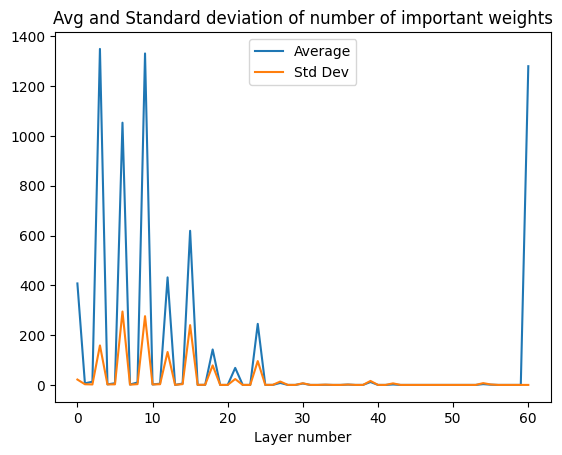

In [8]:
num_imp = {}
for layer_num, (name, param) in enumerate(model.named_parameters()):
    num_imp[name] = [len(imp_wts[rd][layer_num]) for rd in range(len(imp_wts))]

plt.plot(np.average(np.array(list(num_imp.values())), axis=1), label='Average')
plt.plot(np.std(np.array(list(num_imp.values())), axis=1), label='Std Dev')
plt.xlabel('Layer number')
plt.title('Avg and Standard deviation of number of important weights')
plt.legend()
plt.show()

In [58]:
np.around(np.average(np.array(list(num_imp.values())), axis=1), decimals=1)

array([4.0640e+02, 6.9000e+00, 1.3900e+01, 1.4777e+03, 3.0000e+00,
       8.3000e+00, 1.3141e+03, 1.6000e+00, 8.4000e+00, 1.1837e+03,
       1.4000e+00, 5.4000e+00, 5.2830e+02, 1.0000e-01, 3.1000e+00,
       3.4790e+02, 0.0000e+00, 0.0000e+00, 1.6560e+02, 0.0000e+00,
       0.0000e+00, 5.1700e+01, 0.0000e+00, 0.0000e+00, 1.8440e+02,
       0.0000e+00, 0.0000e+00, 1.1000e+01, 0.0000e+00, 0.0000e+00,
       2.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 2.6000e+00, 0.0000e+00, 0.0000e+00, 4.6000e+00,
       0.0000e+00, 0.0000e+00, 6.0000e-01, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e-01, 0.0000e+00, 0.0000e+00, 1.1000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       1.2800e+03])

In [61]:
for k,v in num_imp.items():
    if np.average(v) >= 5:
        print(k)

conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer2.0.conv1.weight
layer2.0.conv2.weight
layer2.0.shortcut.0.weight
layer2.1.conv1.weight
layer2.1.conv2.weight
linear.weight


In [67]:
for name, param in model.named_parameters():
    if 'conv' not in name:
        print(name)

bn1.weight
bn1.bias
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.shortcut.0.weight
layer2.0.shortcut.1.weight
layer2.0.shortcut.1.bias
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.shortcut.0.weight
layer3.0.shortcut.1.weight
layer3.0.shortcut.1.bias
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.bn2.weight
layer4.0.bn2.bias
layer4.0.shortcut.0.weight
layer4.0.shortcut.1.weight
layer4.0.shortcut.1.bias
layer4.1.bn1.weight
layer4.1.bn1.bias
layer4.1.bn2.weight
layer4.1.bn2.bias
linear.weight


In [51]:
list(num_imp.keys())

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.shortcut.0.weight',
 'layer2.0.shortcut.1.weight',
 'layer2.0.shortcut.1.bias',
 'layer2.1.conv1.weight',
 'layer2.1.bn1.weight',
 'layer2.1.bn1.bias',
 'layer2.1.conv2.weight',
 'layer2.1.bn2.weight',
 'layer2.1.bn2.bias',
 'layer3.0.conv1.weight',
 'layer3.0.bn1.weight',
 'layer3.0.bn1.bias',
 'layer3.0.conv2.weight',
 'layer3.0.bn2.weight',
 'layer3.0.bn2.bias',
 'layer3.0.shortcut.0.weight',
 'layer3.0.shortcut.1.weight',
 'layer3.0.shortcut.1.bias',
 'layer3.1.conv1.weight',
 'layer3.1.bn1.weight',
 'l

In [47]:
# for i, (name, param) in enumerate(model.named_parameters()):
#     print(i, name, param.shape)
len(np.average(np.array(list(num_imp.values())), axis=1))

61

## Minibatch class composition

In [3]:
import pickle
import numpy as np

# filename = "check_bait_25K"
filename = "random_mask_exp_25K"
BAIT_qd_idxs = pickle.load(open("Save/Queried_idxs/" + "BAIT_queried_idxs_" + filename + ".p", "rb"))
print(len(BAIT_qd_idxs), type(BAIT_qd_idxs[0]))
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_" + filename + ".p", "rb"))
type(dataset)

12 <class 'numpy.ndarray'>


dict

In [4]:
BAIT_qd_idxs[0].shape

(2000,)

In [5]:
# print(queried_idxs[0][:10])
Y_tr = dataset['Y_train']
# [Y_tr[idx].item() for idx in queried_idxs[0][:10]]

In [6]:
class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in BAIT_qd_idxs]
print(len(class_composition), len(class_composition[0]))


12 2000


In [11]:
BAIT_class_comp = []
for rd in range(len(class_composition)):
    class_rd = [sum(np.array(class_composition[rd]) == cl) for cl in range(10)]
    BAIT_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))
# np.array(class_composition[0][:10]) == 0

[224, 251, 211, 197, 246, 150, 159, 201, 189, 172] 2000
[246, 110, 233, 235, 234, 184, 237, 158, 161, 202] 2000
[172, 169, 229, 260, 230, 227, 181, 209, 155, 168] 2000
[182, 170, 239, 261, 269, 215, 181, 164, 162, 157] 2000
[220, 118, 226, 276, 226, 259, 190, 213, 138, 134] 2000
[156, 225, 201, 293, 259, 282, 201, 149, 119, 115] 2000
[204, 184, 180, 311, 215, 229, 157, 226, 120, 174] 2000
[181, 106, 174, 238, 231, 294, 222, 182, 221, 151] 2000
[210, 152, 246, 168, 164, 259, 179, 207, 158, 257] 2000
[350, 243, 201, 88, 143, 128, 189, 225, 188, 245] 2000
[155, 286, 189, 60, 113, 88, 307, 247, 302, 253] 2000
[97, 408, 73, 18, 69, 74, 202, 223, 483, 353] 2000


In [2]:
import pickle
import numpy as np

# filename = "check_bait_25K"
filename = "rand_queried_idxs_Random_vs_BAIT_new_rand__for_random_mask_exp_25K"
BAIT_qd_idxs = pickle.load(open("Save/Queried_idxs/" + filename + ".p", "rb"))
print(len(BAIT_qd_idxs), type(BAIT_qd_idxs[0]))
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_Random_vs_BAIT_new" + ".p", "rb"))
type(dataset)

19 <class 'numpy.ndarray'>


dict

In [6]:
Y_tr = dataset['Y_train']

In [7]:
class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in BAIT_qd_idxs]
print(len(class_composition), len(class_composition[0]))

19 275


In [8]:
BAIT_class_comp = []
for rd in range(len(class_composition)):
    class_rd = [sum(np.array(class_composition[rd]) == cl) for cl in range(10)]
    BAIT_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

[13, 234, 13, 15, 0, 0, 0, 0, 0, 0] 275
[11, 250, 4, 10, 0, 0, 0, 0, 0, 0] 275
[10, 238, 16, 11, 0, 0, 0, 0, 0, 0] 275
[18, 230, 17, 10, 0, 0, 0, 0, 0, 0] 275
[12, 240, 11, 12, 0, 0, 0, 0, 0, 0] 275
[7, 240, 11, 17, 0, 0, 0, 0, 0, 0] 275
[12, 234, 12, 17, 0, 0, 0, 0, 0, 0] 275
[6, 244, 10, 15, 0, 0, 0, 0, 0, 0] 275
[10, 244, 9, 12, 0, 0, 0, 0, 0, 0] 275
[16, 232, 14, 13, 0, 0, 0, 0, 0, 0] 275
[13, 234, 19, 9, 0, 0, 0, 0, 0, 0] 275
[13, 228, 15, 19, 0, 0, 0, 0, 0, 0] 275
[10, 245, 14, 6, 0, 0, 0, 0, 0, 0] 275
[10, 241, 8, 16, 0, 0, 0, 0, 0, 0] 275
[11, 249, 5, 10, 0, 0, 0, 0, 0, 0] 275
[11, 242, 11, 11, 0, 0, 0, 0, 0, 0] 275
[14, 243, 11, 7, 0, 0, 0, 0, 0, 0] 275
[13, 237, 13, 12, 0, 0, 0, 0, 0, 0] 275
[20, 231, 12, 12, 0, 0, 0, 0, 0, 0] 275


In [5]:
import pickle
import numpy as np

# filename = "check_bait_25K"
filename = "BAIT_queried_idxs_Random_vs_BAIT_new_rand__for_random_mask_exp_25K"
BAIT_qd_idxs = pickle.load(open("Save/Queried_idxs/" + filename + ".p", "rb"))
print(len(BAIT_qd_idxs), type(BAIT_qd_idxs[0]))
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_Random_vs_BAIT_new" + ".p", "rb"))
type(dataset)

19 <class 'numpy.ndarray'>


dict

In [6]:
Y_tr = dataset['Y_train']

In [7]:
class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in BAIT_qd_idxs]
print(len(class_composition), len(class_composition[0]))

19 275


In [8]:
BAIT_class_comp = []
for rd in range(len(class_composition)):
    class_rd = [sum(np.array(class_composition[rd]) == cl) for cl in range(10)]
    BAIT_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

[44, 131, 50, 50, 0, 0, 0, 0, 0, 0] 275
[42, 154, 38, 41, 0, 0, 0, 0, 0, 0] 275
[40, 123, 57, 55, 0, 0, 0, 0, 0, 0] 275
[42, 178, 28, 27, 0, 0, 0, 0, 0, 0] 275
[28, 210, 16, 21, 0, 0, 0, 0, 0, 0] 275
[13, 236, 17, 9, 0, 0, 0, 0, 0, 0] 275
[5, 239, 12, 19, 0, 0, 0, 0, 0, 0] 275
[6, 257, 4, 8, 0, 0, 0, 0, 0, 0] 275
[4, 266, 2, 3, 0, 0, 0, 0, 0, 0] 275
[1, 271, 2, 1, 0, 0, 0, 0, 0, 0] 275
[0, 274, 0, 1, 0, 0, 0, 0, 0, 0] 275
[3, 272, 0, 0, 0, 0, 0, 0, 0, 0] 275
[1, 274, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[1, 274, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275


In [1]:
import pickle
import numpy as np

# filename = "check_bait_25K"
filename = "BAIT_queried_idxs_Random_vs_BAIT_new_2"
BAIT_qd_idxs = pickle.load(open("Save/Queried_idxs/" + filename + ".p", "rb"))
print(len(BAIT_qd_idxs), type(BAIT_qd_idxs[0]))
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_Random_vs_BAIT_new_2" + ".p", "rb"))
type(dataset)

19 <class 'numpy.ndarray'>


dict

In [2]:
Y_tr = dataset['Y_train']

In [3]:
class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in BAIT_qd_idxs]
print(len(class_composition), len(class_composition[0]))

19 275


In [4]:
BAIT_class_comp = []
for rd in range(len(class_composition)):
    class_rd = [sum(np.array(class_composition[rd]) == cl) for cl in range(10)]
    BAIT_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

[28, 166, 46, 35, 0, 0, 0, 0, 0, 0] 275
[28, 175, 42, 30, 0, 0, 0, 0, 0, 0] 275
[54, 141, 31, 49, 0, 0, 0, 0, 0, 0] 275
[28, 148, 52, 47, 0, 0, 0, 0, 0, 0] 275
[40, 185, 25, 25, 0, 0, 0, 0, 0, 0] 275
[20, 221, 16, 18, 0, 0, 0, 0, 0, 0] 275
[13, 237, 9, 16, 0, 0, 0, 0, 0, 0] 275
[8, 246, 14, 7, 0, 0, 0, 0, 0, 0] 275
[6, 269, 0, 0, 0, 0, 0, 0, 0, 0] 275
[2, 272, 0, 1, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[1, 274, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[1, 274, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275
[0, 275, 0, 0, 0, 0, 0, 0, 0, 0] 275


Per class test accuracy of the model trained with BAIT

In [34]:
import pickle
import numpy as np
import resnet
from saving import load_model
# filename = "check_bait_25K"
filename = "Random_vs_BAIT_avg"
net = resnet.ResNet18(num_classes=4)
load_model(15, net, filename, "BAIT")
dataset = pickle.load(open("Save/Queried_idxs/" + "dataset_" + filename + ".p", "rb"))
type(dataset)

dict

In [4]:
from query_strategies.bait_sampling import BaitSampling
from torchvision import transforms
import torch
from dataset import get_dataset, get_handler
X_tr, Y_tr, X_te, Y_te = get_dataset('CIFAR10', 'data')


Files already downloaded and verified
Files already downloaded and verified


In [3]:
def unbalanced_test_dataset(X_tr, Y_tr):
   
    masks = [np.zeros(len(Y_tr), dtype = 'int') for i in range(10)]
    for i in range(len(Y_tr)):
        masks[Y_tr[i].item()][i] = 1

    var = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[0] == 1], 1000, replace=False)
    var2 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[1] == 1], 1000, replace=False)
    var3 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[2] == 1], 1000, replace=False)
    var4 = np.random.choice(np.arange(len(X_tr), dtype=int)[masks[3] == 1], 1000, replace=False)
    
    new_Xtr = np.concatenate((X_tr[var], X_tr[var2], X_tr[var3], X_tr[var4]))
    new_Ytr = np.zeros(len(new_Xtr), dtype = 'int')
    new_Ytr[0:1000] = 0
    new_Ytr[1000: 2000] = 1
    
    new_Ytr[2000: 3000] = 2
    new_Ytr[3000 : 4000] = 3
    return new_Xtr, torch.from_numpy(new_Ytr)
X_te, Y_te = unbalanced_test_dataset(X_te, Y_te)

In [20]:
X_tr = dataset['X_train']
Y_tr = dataset['Y_train']
idxs_lb = 5750
args = {'transform':transforms.Compose([transforms.ToTensor()]),
                'n_epoch':10,
                'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                'loader_te_args':{'batch_size': 100, 'num_workers': 1},
                'optimizer_args':{'lr': 0.01, 'momentum': 0},
                'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))]),
                'fishIdentity' : 0,
                'fishInit': 1,
                'lamb':1,
                'backwardSteps':1,
                'savefile': "Random_vs_BAIT_new",
                'chunkSize': 200}
handler = get_handler('CIFAR10')


# strategy = BaitSampling(X_tr, Y_tr, idxs_lb, net, handler, args)

In [19]:
strategy.clf = net.cuda()

In [20]:
P = strategy.predict(X_te, Y_te)

In [21]:
print(P)

tensor([2, 2, 0,  ..., 2, 2, 2])


In [22]:
accur = 1.0 * (Y_te == P).sum().item() / len(Y_te)

In [23]:
print(accur)

0.3815


In [21]:
from torch.autograd import Variable
from torch.utils.data import DataLoader
def predict(net,X, Y):
    if type(X) is np.ndarray:
        loader_te = DataLoader(handler(X, Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])
    else: 
        loader_te = DataLoader(handler(X.numpy(), Y, transform=args['transformTest']),
                        shuffle=False, **args['loader_te_args'])

    net.eval()
    P = torch.zeros(len(Y)).long()
    with torch.no_grad():
        for x, y, idxs in loader_te:
            x, y = Variable(x), Variable(y)
            out, e1 = net(x)
            pred = out.max(1)[1]
            P[idxs] = pred.data.cpu()
    return P

In [8]:
P = predict(net, X_te, Y_te)

In [29]:
sum(P==2)

tensor(5689)

In [30]:
sum(Y_tr==2)

tensor(250)

In [53]:
accur = 1.0 * (Y_te == P).sum().item() / len(Y_te)

In [54]:
print(accur)

0.6545


In [35]:
masks = [np.zeros(len(Y_te), dtype = 'int') for i in range(10)]
for i in range(len(Y_te)):
    masks[Y_te[i].item()][i] = 1

X_te_0 = X_te[np.arange(len(X_te), dtype=int)[masks[0] == 1]]
X_te_1 = X_te[np.arange(len(X_te), dtype=int)[masks[1] == 1]]
X_te_2 = X_te[np.arange(len(X_te), dtype=int)[masks[2] == 1]]
X_te_3 = X_te[np.arange(len(X_te), dtype=int)[masks[3] == 1]]

Y_te_0 = torch.from_numpy(np.array([0]*1000))
Y_te_1 = torch.from_numpy(np.array([1]*1000))
Y_te_2 = torch.from_numpy(np.array([2]*1000))
Y_te_3 = torch.from_numpy(np.array([3]*1000))

In [36]:
P = predict(net,X_te_0, Y_te_0)

In [24]:
accur = 1.0 * (Y_te_0 == P).sum().item() / len(Y_te_0)

In [25]:
print(accur)

0.575


In [26]:
def check_acc(net,X,Y):
    P = predict(net,X, Y)
    accur = 1.0 * (Y == P).sum().item() / len(Y)
    return accur


In [27]:
check_acc(net,X_te_1, Y_te_1)

0.984

In [28]:
check_acc(net,X_te_2, Y_te_2)

0.52

In [29]:
check_acc(net,X_te_3, Y_te_3)

0.636

In [42]:
class_0 ,class_1 , class_2 , class_3 = [], [], [], []

In [44]:
class_0 ,class_1 , class_2 , class_3 = [], [], [], []
for i in range(1,16):
    load_model(i, net, filename, "BAIT")
    class_0.append(check_acc(net,X_te_0, Y_te_0))
    class_1.append(check_acc(net,X_te_1, Y_te_1))
    class_2.append(check_acc(net,X_te_2, Y_te_2))
    class_3.append(check_acc(net,X_te_3, Y_te_3))
    
    

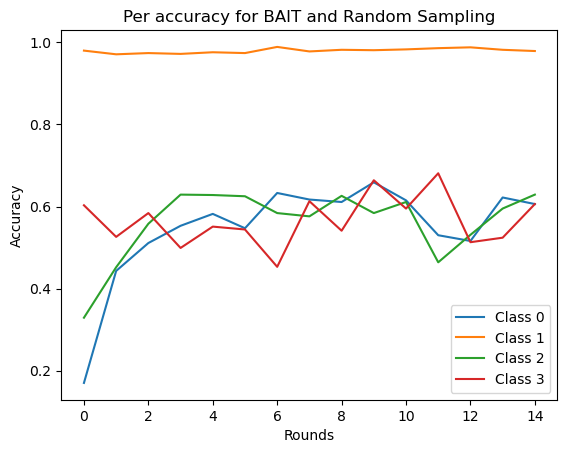

In [45]:
import matplotlib.pyplot as plt
plt.plot(class_0, label='Class 0')
plt.plot(class_1, label="Class 1")
plt.plot(class_2, label="Class 2")
plt.plot(class_3, label="Class 3")
plt.title('Per accuracy for BAIT and Random Sampling')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

checking class composition for random mask BAIT -- called FISH in the expermeint

In [8]:
FISH_qd_idxs = pickle.load(open("Save/Queried_idxs/" + "FISH_queried_idxs_" + filename + ".p", "rb"))
print(len(FISH_qd_idxs))

FISH_class_composition = [[Y_tr[idx].item() for idx in rd_idxs] for rd_idxs in FISH_qd_idxs]
print(len(FISH_class_composition), len(FISH_class_composition[0]))

12
12 2000


In [12]:
FISH_class_comp = []
for rd in range(len(FISH_class_composition)):
    class_rd = [sum(np.array(FISH_class_composition[rd]) == cl) for cl in range(10)]
    FISH_class_comp.append(class_rd)
    print(class_rd, sum(class_rd))

[264, 179, 235, 215, 220, 173, 138, 242, 186, 148] 2000
[198, 153, 200, 212, 256, 208, 198, 206, 186, 183] 2000
[219, 186, 213, 256, 203, 202, 158, 193, 181, 189] 2000
[183, 205, 216, 232, 192, 224, 183, 191, 182, 192] 2000
[166, 165, 270, 219, 176, 243, 185, 214, 159, 203] 2000
[216, 229, 191, 201, 160, 212, 177, 220, 192, 202] 2000
[171, 186, 208, 234, 205, 244, 194, 194, 207, 157] 2000
[196, 184, 213, 202, 176, 222, 225, 218, 148, 216] 2000
[176, 266, 217, 164, 177, 195, 220, 174, 221, 190] 2000
[173, 205, 206, 189, 186, 223, 190, 197, 207, 224] 2000
[207, 297, 145, 150, 162, 180, 220, 200, 232, 207] 2000
[228, 167, 88, 131, 286, 63, 317, 155, 295, 270] 2000


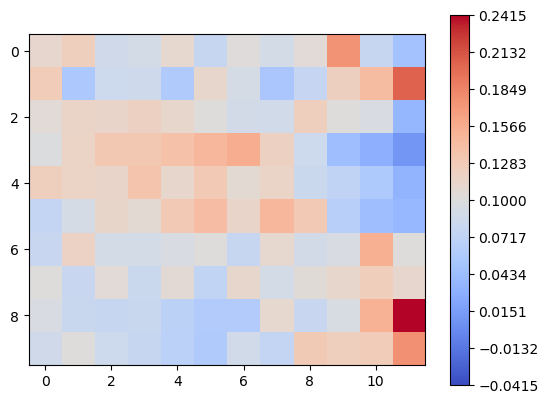

In [32]:
import matplotlib.pyplot as plt

class_comp = BAIT_class_comp
class_proportion = np.array(class_comp).T / 2000

half_range = max(0.1 - np.amin(class_proportion), np.amax(class_proportion) - 0.1)
cbar_min, cbar_max = 0.1 - half_range, 0.1 + half_range
cbar_ticks = np.linspace(cbar_min, cbar_max, 11)

plot = plt.imshow(class_proportion, vmin=cbar_min, vmax=cbar_max, cmap='coolwarm')
cbar = plt.colorbar(plot)
cbar.set_ticks(cbar_ticks)
plt.show()

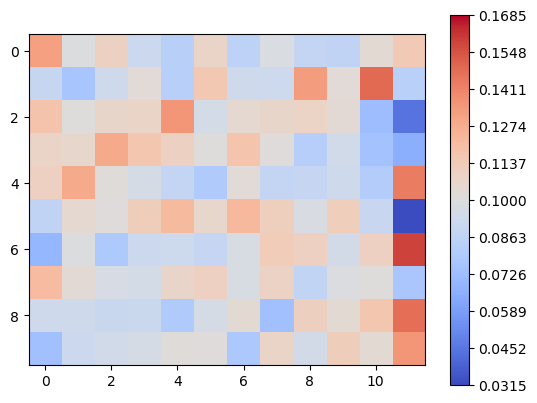

In [33]:
class_comp = FISH_class_comp
class_proportion = np.array(class_comp).T / 2000

half_range = max(0.1 - np.amin(class_proportion), np.amax(class_proportion) - 0.1)
cbar_min, cbar_max = 0.1 - half_range, 0.1 + half_range
cbar_ticks = np.linspace(cbar_min, cbar_max, 11)

plot = plt.imshow(class_proportion, vmin=cbar_min, vmax=cbar_max, cmap='coolwarm')
cbar = plt.colorbar(plot)
cbar.set_ticks(cbar_ticks)
plt.show()

In [17]:
init_mask = pickle.load(open("Save/Queried_idxs/" + "initLabeled_" + filename + ".p", "rb"))
init_idxs = np.where(init_mask)[0]
init_class = np.array([find_class(b) for b in init_idxs])
[sum(init_class == cl) for cl in range(10)]

[94, 96, 101, 99, 102, 111, 90, 97, 109, 101]

In [1]:
import pickle
filename = 'Compare'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [3]:
print([a for a in rd_accuracies['rand']])

[0.5595, 0.6508, 0.6593, 0.6895, 0.7091, 0.7457, 0.7548, 0.7583, 0.7893, 0.8044, 0.7933, 0.8093]


In [36]:
print([a for a in rd_accuracies['BAIT'][2:]])
print([a for a in rd_accuracies['FISH']])

[0.5546, 0.6196, 0.6794, 0.7096, 0.7369, 0.7488, 0.758, 0.7874, 0.7997, 0.7977, 0.806, 0.8115]
[0.5503, 0.6282, 0.6554, 0.6854, 0.6959, 0.7483, 0.7662, 0.7647, 0.7803, 0.7968, 0.8005, 0.8006]


Accuracy for Random Sampling on 2 classes

In [2]:
import pickle
filename = 'small_exp'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [3]:
print([a for a in rd_accuracies['rand']])

[0.904, 0.9165, 0.908, 0.9175, 0.922, 0.9435, 0.9365, 0.942, 0.94, 0.96, 0.9495, 0.9455, 0.9625, 0.9615]


Accuracy for BAIT Sampling on 2 classes

In [1]:
import pickle
filename = 'Random_vs_BAIT'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [2]:
print([a for a in rd_accuracies['BAIT']])

[0.908, 0.9165, 0.9315, 0.951, 0.9455, 0.949, 0.959, 0.953, 0.964, 0.96, 0.9645, 0.965, 0.968, 0.962]


Accuracy for Random Sampling and BAIT without using weight parameter on 2 classes (nQuery=50)

In [1]:
import pickle
filename = 'Random_vs_BAIT_wo_weight'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [2]:
print([a for a in rd_accuracies['BAIT']])
print([a for a in rd_accuracies['rand']])

[0.83, 0.8525, 0.8635, 0.8675, 0.869, 0.8415, 0.8575]
[0.754, 0.8245, 0.8285, 0.847, 0.83, 0.867, 0.873]


Accuracy for Random Sampling and BAIT without using weight parameter on 2 classes (nQuery=500)

In [3]:
import pickle
filename = 'Random_vs_BAIT_wo_weight_2'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [4]:
print([a for a in rd_accuracies['BAIT']])
print([a for a in rd_accuracies['rand']])

[0.8755, 0.923, 0.9195, 0.9425, 0.949, 0.952, 0.9555, 0.9635, 0.954, 0.9615, 0.945, 0.959, 0.9515, 0.969]
[0.8895, 0.9025, 0.9215, 0.93, 0.9435, 0.941, 0.953, 0.953, 0.9415, 0.9535, 0.9655, 0.951, 0.9605, 0.9605]


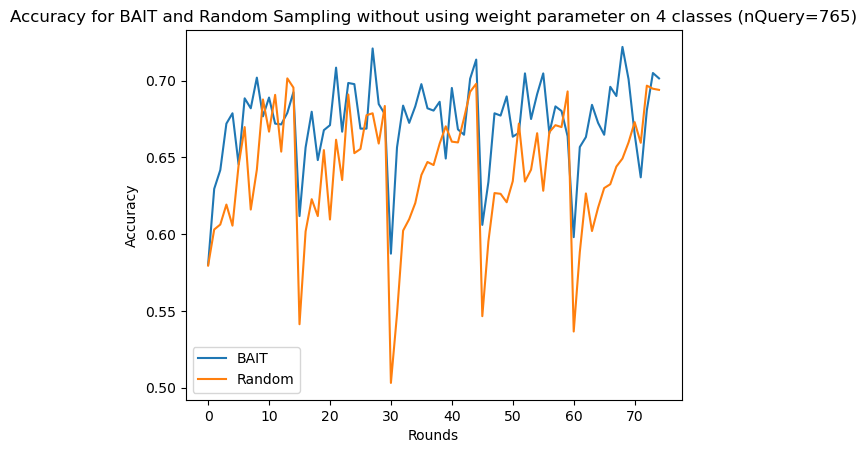

In [77]:
import matplotlib.pyplot as plt

plt.plot([rd_accuracies['BAIT'][r] for r in range(len(rd_accuracies['BAIT']))], label='BAIT')
plt.plot([rd_accuracies['rand'][r] for r in range(len(rd_accuracies['rand']))], label="Random")
plt.title('Accuracy for BAIT and Random Sampling without using weight parameter on 4 classes (nQuery=765)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Accuracy of FISH using unbalanced dataset

In [78]:
import pickle
import numpy as np
FISH_accur_list = []
filename = 'BAIT_w_randmask0'
rd_accuracies_fish_0 = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
acc_0 = [a for a in rd_accuracies_fish_0['FISH']]
FISH_accur_list.append(acc_0)
type(rd_accuracies)

dict

In [79]:
filename = 'BAIT_w_randmask1'
rd_accuracies_fish_1 = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
acc_1 = [a for a in rd_accuracies_fish_1['FISH']]
FISH_accur_list.append(acc_1)

In [80]:
filename = 'BAIT_w_randmask2'
rd_accuracies_fish_2 = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
acc_2 = [a for a in rd_accuracies_fish_2['FISH']]
FISH_accur_list.append(acc_2)

In [81]:
filename = 'BAIT_w_randmask3'
rd_accuracies_fish_3 = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
acc_3 = [a for a in rd_accuracies_fish_3['FISH']]
FISH_accur_list.append(acc_3)

In [82]:
filename = 'BAIT_w_randmask4'
rd_accuracies_fish_4 = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
acc_4 = [a for a in rd_accuracies_fish_4['FISH']]
FISH_accur_list.append(acc_4)

In [83]:
avg_fish_accur = np.average(FISH_accur_list, axis=0)

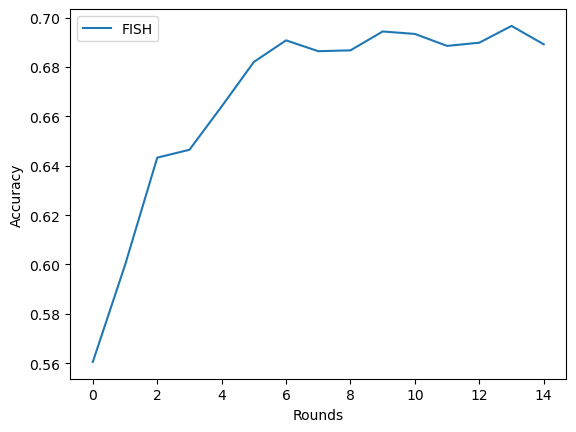

In [84]:
import matplotlib.pyplot as plt

plt.plot(avg_fish_accur, label='FISH')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Comparison of accuracies of all 3 algorithms

In [88]:
import pickle
filename = 'Random_vs_BAIT_avg'
rd_accuracies = pickle.load(open("Save/Round_accuracies/" + "Accuracy_for_" + filename + ".p", "rb"))
type(rd_accuracies)

dict

In [93]:
bait_acc = [a for a in rd_accuracies['BAIT']]
rand_acc = [a for a in rd_accuracies['rand']]
bait_avg = np.average(np.row_stack([bait_acc[t * 15 : (t + 1)*15] for t in range(5)]), axis=0)
rand_avg = np.average(np.row_stack([rand_acc[t * 15 : (t + 1)*15] for t in range(5)]), axis=0)

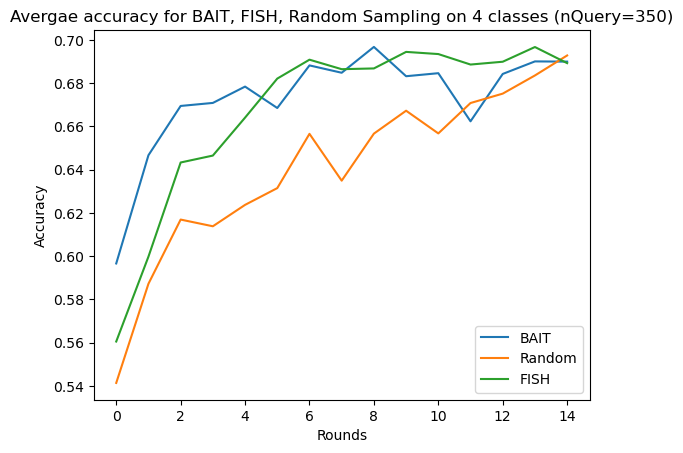

In [95]:
import matplotlib.pyplot as plt

plt.plot(bait_avg, label='BAIT')
plt.plot(rand_avg, label="Random")
plt.plot(avg_fish_accur, label='FISH')
plt.title('Avergae accuracy for BAIT, FISH, Random Sampling on 4 classes (nQuery=350)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

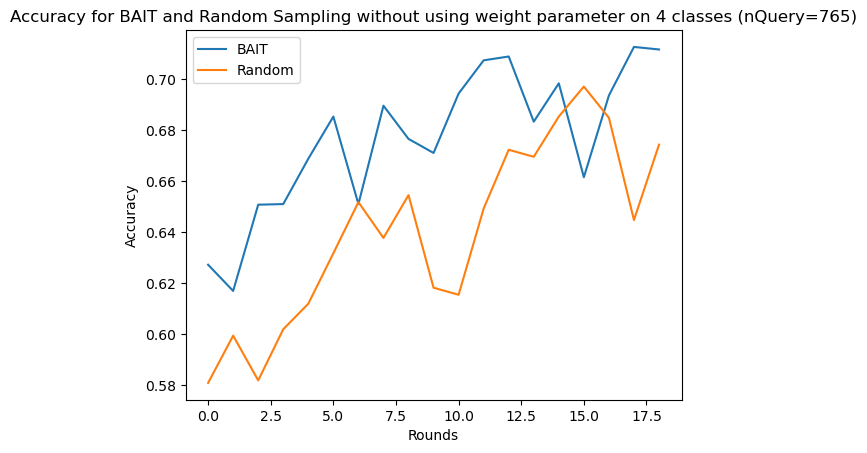

In [86]:
import matplotlib.pyplot as plt

plt.plot([rd_accuracies['BAIT'][r] for r in range(len(rd_accuracies['BAIT']))], label='BAIT')
plt.plot([rd_accuracies['rand'][r] for r in range(len(rd_accuracies['rand']))], label="Random")
plt.title('Accuracy for BAIT and Random Sampling without using weight parameter on 4 classes (nQuery=765)')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

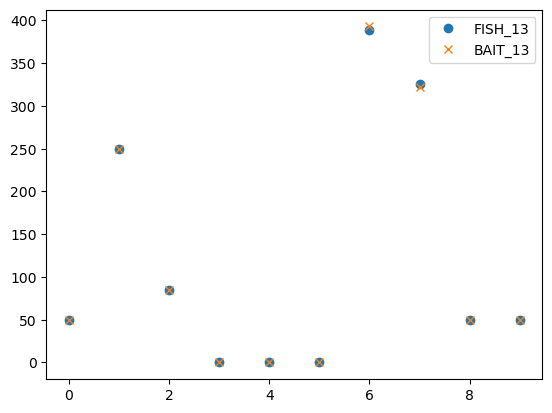

In [ ]:
for rd in range(13, 14):
    plt.plot([sum(np.array(class_composition[rd]) == cl) for cl in range(10)], 'o', label=F'FISH_{rd}')
    plt.plot([sum(bait_class[rd] == cl) for cl in range(10)], 'x', label=F'BAIT_{rd}')

plt.legend()
plt.show()

# Plot of accuracy

In [ ]:
import pickle
exp_savefile = "exper25K_1per_aug_chunkfix"
exp_savefile2 = "exper25K_1per_bait"
rd_accs = pickle.load(open("Save/Round_accuracies/Accuracy_for_" + exp_savefile + ".p", "rb"))
rd_accs2 = pickle.load(open("Save/Round_accuracies/Accuracy_for_" + exp_savefile2 + ".p", "rb"))

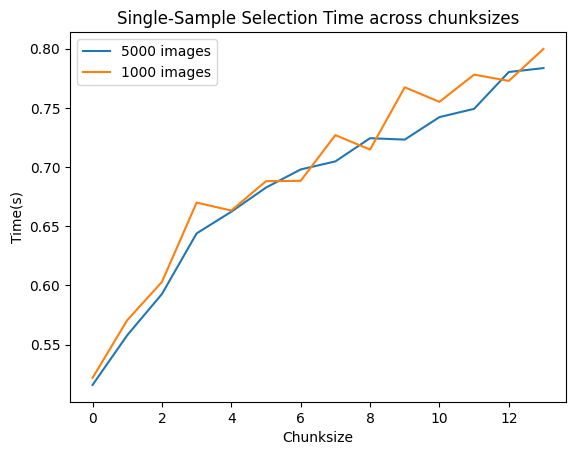

In [ ]:
import matplotlib.pyplot as plt
""" plt.plot([rd_accs['FISH'][r] for r in range(len(rd_accs['FISH']))], label='BAIT with FISH Mask')
plt.plot([rd_accs2['BAIT'][r] for r in range(14)], label='Standard BAIT')
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('ResNet-18 Test Accuracy trained on reduced CIFAR10 25K dataset size') """
plt.plot([rd_accs['FISH'][r] for r in range(len(rd_accs['FISH']))], label="5000 images")#label='BAIT with FISH Mask')
plt.plot([rd_accs2['BAIT'][r] for r in range(14)], label="1000 images")#label='Standard BAIT')
#plt.xlabel('Rounds')
#plt.ylabel('Accuracy')
plt.xlabel('Chunksize')
plt.ylabel('Time(s)')
plt.title("Single-Sample Selection Time across chunksizes")
plt.legend()
#plt.savefig("accuracyplot.png", format="png", dpi=5000)
plt.show()

In [ ]:
# list(rd_accs.keys())
# len(rd_accs['FISH'])
rd_accs['FISH']

[0.516,
 0.558,
 0.5928,
 0.644,
 0.6623,
 0.6827,
 0.698,
 0.7048,
 0.7244,
 0.7232,
 0.7422,
 0.7492,
 0.7803,
 0.7836]

# Debug last-layer important weight selection issue

In [ ]:
import torch
# import importlib
# ann = importlib.import_module("active-nn")

import resnet

In [ ]:
import numpy as np
import pickle

imp_wts = pickle.load(open("./Save/Imp_weights/imp_wts_idxs_exper25K_1per.p", "rb"))
type(imp_wts) 

list

In [ ]:
len(imp_wts)

12

In [ ]:
error_rd_imp_wts = imp_wts[-1]
type(error_rd_imp_wts)

list

In [ ]:
len(error_rd_imp_wts)

61

In [ ]:
model = resnet.ResNet18()
filename = "exper25K_1per"
error_rd = 12
model.load_state_dict(torch.load("./Save/Models/"+ filename +"/model_" +  str(error_rd) + ".pt"))

<All keys matched successfully>

In [ ]:
saved_dataset = pickle.load(open("./Save/Queried_idxs/dataset_exper25K_1per.p", "rb"))
type(saved_dataset)

dict

In [ ]:
# list(saved_dataset.keys())
X_tr, Y_tr = saved_dataset['X_train'], saved_dataset['Y_train']

In [ ]:
idxs_lb = pickle.load(open("./Save/Queried_idxs/queried_idxs_exper25K_1per.p", "rb"))
type(idxs_lb)

list

In [ ]:
error_rd_idxs_lb = idxs_lb[-1]
type(error_rd_idxs_lb)

numpy.ndarray

In [ ]:
idxs_lb_before_error = []
for idxs in idxs_lb:
    idxs_lb_before_error.extend(idxs)

len(idxs_lb_before_error)

13200

In [ ]:
from torchvision import transforms
import dataset as D 
import vgg



handler = D.get_handler("CIFAR10")
args = {'n_epoch': 3, 'transform': transforms.Compose([ 
                        transforms.RandomCrop(32, padding=4),
                        transforms.RandomHorizontalFlip(),
                        transforms.ToTensor(),
                        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
                    ]),
                    'loader_tr_args':{'batch_size': 128, 'num_workers': 1},
                    'loader_te_args':{'batch_size': 100, 'num_workers': 1}, # change back to 1000
                    'optimizer_args':{'lr': 0.05, 'momentum': 0.3},
                    'transformTest': transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])}


args['fishIdentity'] = 0
args['fishInit'] = 1
args['lamb'] = 1
args['backwardSteps'] = 0
args['pct_top'] = 0.01
args['savefile'] = "exper25K_1per"


/usr/local/home/sgchr/anaconda3/envs/pyt/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /usr/local/home/sgchr/anaconda3/envs/pyt/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
# lp_grads = strategy.log_prob_grads_wrt(error_rd_imp_wts)

In [ ]:
num_imp_per_layer = [len(t) for t in error_rd_imp_wts]
log_prob_grads = np.zeros((len(Y_tr), len(np.unique(Y_tr)), sum(num_imp_per_layer))) 

In [ ]:
from torch.utils.data import DataLoader


masks_list = []
for layer_num, layer_wt in enumerate(list(model.parameters())):
    mask = np.zeros_like(layer_wt.detach().cpu().numpy(), dtype=bool)
    for tup in error_rd_imp_wts[layer_num]:
        mask[tup] = True
    masks_list.append(mask)

model.to('cuda')
for param in model.parameters():
    param.requires_grad = True
model.eval()
parameters = tuple(model.parameters())
    
test_loader = DataLoader(handler(X_tr, Y_tr, transform=args['transform']), shuffle=False, **args['loader_te_args']) # 'transformTest'


In [ ]:
len(error_rd_imp_wts[60])

1285

In [ ]:
np.sum(masks_list[-1])

1280

In [ ]:
sq_grads = {i: np.random.uniform(size=p.shape) for i, p in enumerate(parameters)}

In [ ]:
sq_grads[60] = 1 + sq_grads[60]

In [ ]:
sq_grads[60][3,4]

1.6184818651513364

In [ ]:
def calculate_mask(sq_grads_expect, pct_top=0.02):
    list_t = list(sq_grads_expect.values())
    combined_arrays = np.hstack([t.flatten() for t in sq_grads_expect.values()]) 
    list_lengths = [len(ten.flatten()) for ten in list_t]
    cum_lengths = np.cumsum(list_lengths)
    sorted_idxs = np.argsort(combined_arrays[:cum_lengths[-2]])
    num_top = int(pct_top * len(combined_arrays))
    # top_idxs = sorted_idxs[-num_top:]

    num_last_layer = sum(list_lengths[-1:]) 
    # in FISH ResNet architecture, the last layer has bias=False
    # if last layer has both weight and bias, set -1 to -2 above

    if num_last_layer < num_top:
        top_idxs = np.hstack(
            [sorted_idxs[-(num_top - num_last_layer):], 
            np.arange(cum_lengths[-2], cum_lengths[-1])]
        )
        assert len(top_idxs) == num_top
    else:
        raise ValueError("too small top percentage")

    imp_wt_idxs = [[] for i in range(len(list_t))]
    for idx in top_idxs:
        prev_length = 0
        for idx_layer_num, length in enumerate(cum_lengths):
            if idx < length and length > prev_length: 
                # print(len_idx)
                try:
                    # s_num[len_idx].append(np.where(combined_s[idx] == list_s[len_idx])[0][0])
                    idx_tuple = np.nonzero(combined_arrays[idx] == list_t[idx_layer_num])
                    '''pass only numpy or python objects to numpy functions'''
                    # s_num[len_idx].append([idx[0] for idx in idx_tuple])
                    imp_wt_idxs[idx_layer_num].append(idx_tuple)
                except Exception:
                    print("caught error: ", idx, idx_layer_num, length, imp_wt_idxs)
                    raise
                break
            prev_length = length
    return imp_wt_idxs

test_imp_wts = calculate_mask(sq_grads, 0.01)

In [ ]:
len(test_imp_wts[60])

1280

In [ ]:
print([len(test_imp_wts[i]) for i in range(len(test_imp_wts))])

[0, 0, 0, 13, 0, 2, 16, 0, 0, 23, 0, 0, 33, 0, 0, 40, 0, 0, 83, 0, 1, 4, 1, 0, 67, 0, 0, 80, 0, 0, 119, 0, 2, 305, 0, 0, 10, 0, 0, 325, 0, 0, 301, 0, 1, 604, 0, 0, 1177, 1, 0, 73, 2, 1, 1204, 2, 1, 1241, 2, 0, 1280]


In [ ]:
import matplotlib.pyplot as plt
# file = open("./Save/chunksize_experiment_logs/exper1000_chunk50.log")
def plot_chunktimes(debug_size, chunkSizes):
    for c in chunkSizes:
        with open(F"./Save/chunksize_experiment_logs/exper{debug_size}_chunk" + F"{c}" + ".log") as file:
            lines = file.readlines()
            num = []
            for line in lines:
                if "Select" in line: #  "Average" 
                    for x, i in enumerate(line):
                        if i.isdigit():
                            num.append(float(line[x:-8]))
                            break
        plt.plot([num[i] for i in range(len(num))], label=F"chunk_{c}")
    
    plt.xlabel('Rounds')
    plt.ylabel('Time(seconds)')
    plt.title(F"Select function time across rounds for size {debug_size} with differing chunksizes")
    plt.legend()
    plt.show()


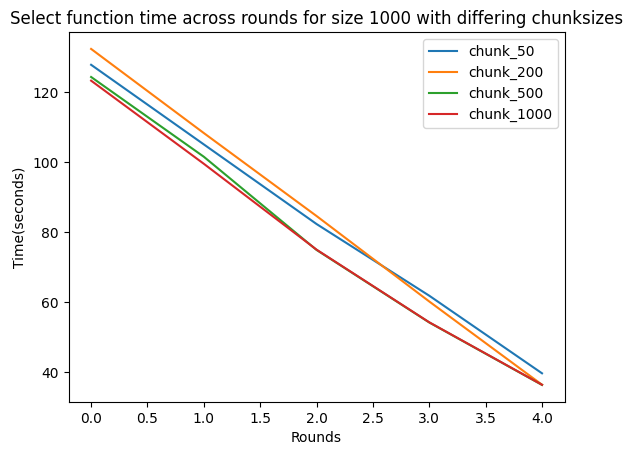

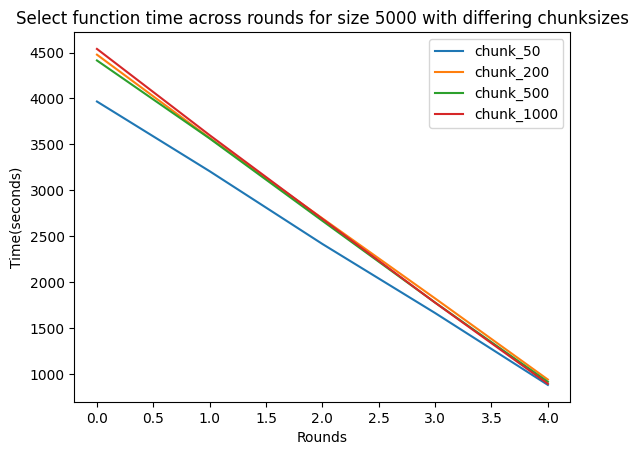

In [ ]:
chunkSizes = [50, 200, 500, 1000]
plot_chunktimes(1000, chunkSizes)
plot_chunktimes(5000, chunkSizes)

Accuracies comparison (Standarad Bait vs Random Mask)

In [ ]:
import os
os.chdir('/usr/local/home/sgchr/Documents/active_nn/Save/Round_accuracies/')

In [ ]:
import pickle
import matplotlib.pyplot as plt

filename = 'Accuracy_for_exper25k_stdbaitvsrandmask'
acc_randbait = pickle.load(open( filename + ".p", "rb"))
filename2 = 'Accuracy_for_exper25K_1per_fix'
acc_stdbait = pickle.load(open( filename2 + ".p", "rb"))

# plt.plot(acc_randbait)

In [ ]:
print(acc_randbait)

{'FISH': [], 'BAIT': [0.5568, 0.6511, 0.665, 0.713, 0.7417, 0.7701, 0.7712, 0.7871, 0.5591, 0.6359, 0.6929, 0.7233, 0.7358, 0.7514, 0.7739, 0.7825, 0.7965, 0.8088, 0.8116, 0.8122]}


In [ ]:
print(acc_stdbait)

{'FISH': [0.483, 0.4795, 0.5344, 0.5537, 0.6228, 0.6219, 0.6283, 0.6354, 0.6659, 0.7033, 0.72, 0.7253], 'BAIT': [0.4396, 0.4846, 0.5443, 0.5378, 0.5897, 0.644, 0.6106, 0.6484, 0.6705, 0.7116, 0.729, 0.7267, 0.7358, 0.7667, 0.7677, 0.7756, 0.7927, 0.7937, 0.8067, 0.8125]}


Rewriting Select Code Using Parallelization